# Stress Testing & Scenario Analysis

Portfolio stress testing for coffee commodity trading.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from src.stress_testing import (
    HISTORICAL_SCENARIOS, run_stress_test, run_all_scenarios,
    sensitivity_analysis, reverse_stress_test
)
from src.data_loader import load_csv

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Portfolio Setup

In [8]:
# define our portfolio positions
# positive = long, negative = short

portfolio = {
    'coffee': 5_000_000,      # $5M long coffee exposure
    'equities': 2_000_000,    # $2M equity hedge fund allocation  
    'rates': -500_000,        # $500K short rates (receiver swap)
    'fx_em': 1_000_000        # $1M EM currency exposure
}

total_value = sum(abs(v) for v in portfolio.values())

print("PORTFOLIO POSITIONS")
print("=" * 40)
for asset, value in portfolio.items():
    direction = "Long" if value > 0 else "Short"
    print(f"{asset:<15} {direction:<6} ${abs(value):>12,.0f}")
print("-" * 40)
print(f"{'Total Exposure':<22} ${total_value:>12,.0f}")

PORTFOLIO POSITIONS
coffee          Long   $   5,000,000
equities        Long   $   2,000,000
rates           Short  $     500,000
fx_em           Long   $   1,000,000
----------------------------------------
Total Exposure         $   8,500,000


## 2. Historical Scenario Analysis

In [9]:
# run all predefined historical scenarios
results = run_all_scenarios(portfolio)

print("HISTORICAL STRESS TEST RESULTS")
print("=" * 70)
print(f"{'Scenario':<25} {'Description':<25} {'P&L':>15}")
print("-" * 70)

for _, row in results.iterrows():
    pnl = row['total']
    color = '' if pnl >= 0 else ''
    print(f"{row['scenario']:<25} {row['description'][:24]:<25} ${pnl:>14,.0f}")

print("-" * 70)
print(f"Worst Case: ${results['total'].min():,.0f}")
print(f"Best Case: ${results['total'].max():,.0f}")

HISTORICAL STRESS TEST RESULTS
Scenario                  Description                           P&L
----------------------------------------------------------------------
2008_crisis               Global Financial Crisis   $    -2,990,000
2020_covid                COVID-19 Market Crash     $    -2,252,500
2022_commodity_spike      Post-COVID Commodity Ral  $     1,835,000
brazil_drought            Severe Brazil Drought     $     1,920,000
frost_event               Major Frost in Coffee Re  $     2,700,000
----------------------------------------------------------------------
Worst Case: $-2,990,000
Best Case: $2,700,000


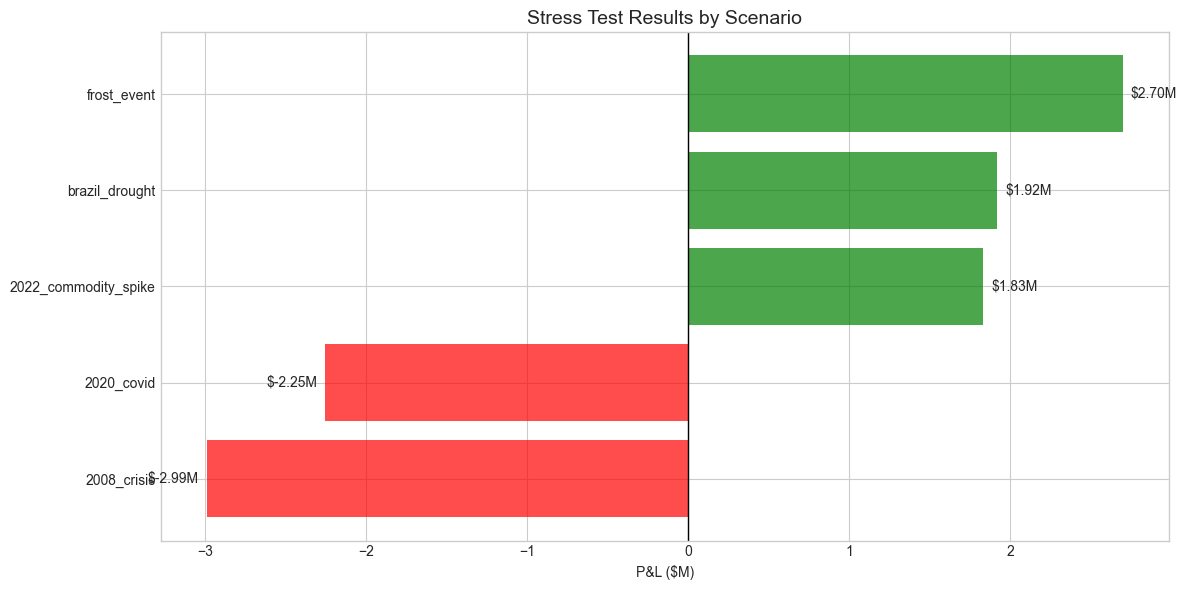

In [10]:
# visualize scenario results
fig, ax = plt.subplots(figsize=(12, 6))

scenarios = results['scenario'].values
pnls = results['total'].values / 1_000_000  # convert to millions

colors = ['green' if p > 0 else 'red' for p in pnls]
bars = ax.barh(scenarios, pnls, color=colors, alpha=0.7)

ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('P&L ($M)')
ax.set_title('Stress Test Results by Scenario', fontsize=14)

for bar, pnl in zip(bars, pnls):
    x = bar.get_width()
    ax.text(x + 0.05 if x > 0 else x - 0.05, bar.get_y() + bar.get_height()/2,
            f'${pnl:.2f}M', va='center', ha='left' if x > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/stress_test_results.png', dpi=150)
plt.show()

## 3. Detailed Scenario Breakdown

In [11]:
# pick worst scenario and break down by asset
worst_idx = results['total'].idxmin()
worst_scenario = results.loc[worst_idx, 'scenario']

print(f"\nWORST CASE BREAKDOWN: {worst_scenario}")
print("=" * 50)

scenario = HISTORICAL_SCENARIOS[worst_scenario]
pnl_breakdown = run_stress_test(portfolio, scenario)

for asset, pnl in pnl_breakdown.items():
    if asset not in ['total', 'description']:
        shock = scenario.get(asset, 0)
        position = portfolio.get(asset, 0)
        print(f"{asset:<15} Position: ${position/1e6:>5.1f}M  Shock: {shock:>+6.0%}  P&L: ${pnl/1e6:>+.2f}M")

print("-" * 50)
print(f"{'TOTAL':<15} {' '*30} P&L: ${pnl_breakdown['total']/1e6:>+.2f}M")


WORST CASE BREAKDOWN: 2008_crisis
coffee          Position: $  5.0M  Shock:   -35%  P&L: $-1.75M
equities        Position: $  2.0M  Shock:   -50%  P&L: $-1.00M
rates           Position: $ -0.5M  Shock:    -2%  P&L: $+0.01M
fx_em           Position: $  1.0M  Shock:   -25%  P&L: $-0.25M
--------------------------------------------------
TOTAL                                          P&L: $-2.99M


## 4. Sensitivity Analysis

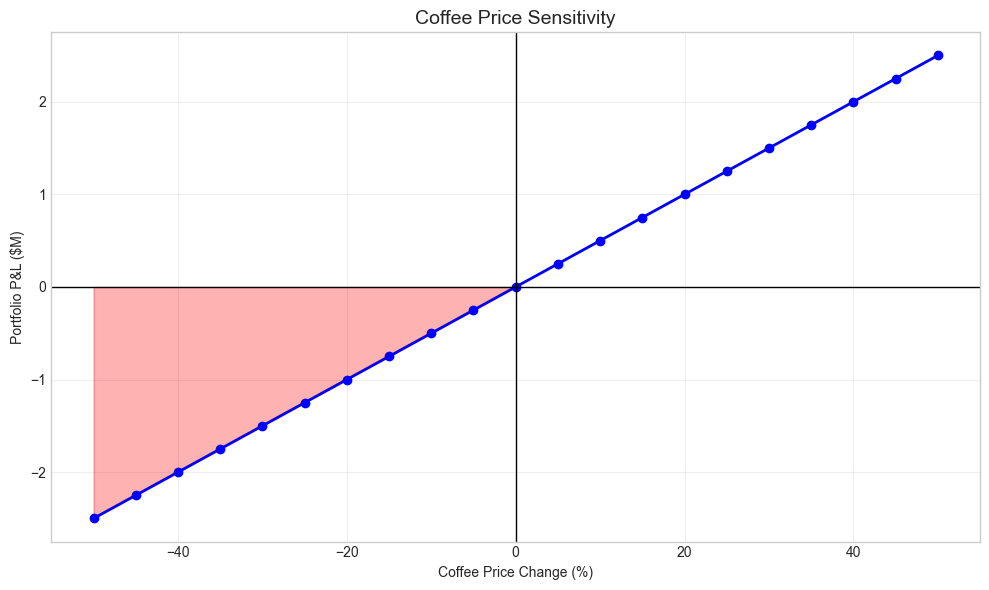


Key Sensitivity Points:
  -30% coffee: $-1.50M
  -10% coffee: $-0.50M
  +10% coffee: $+0.50M
  +30% coffee: $+1.50M


In [12]:
# coffee price sensitivity
shocks = np.arange(-0.50, 0.55, 0.05)  # -50% to +50%
sensitivity = sensitivity_analysis(portfolio, 'coffee', shocks)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sensitivity['shock'] * 100, sensitivity['pnl'] / 1e6, 'b-o', linewidth=2, markersize=6)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# shade loss region
ax.fill_between(sensitivity['shock'] * 100, sensitivity['pnl'] / 1e6, 0,
                where=sensitivity['pnl'] < 0, alpha=0.3, color='red')

ax.set_xlabel('Coffee Price Change (%)')
ax.set_ylabel('Portfolio P&L ($M)')
ax.set_title('Coffee Price Sensitivity', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/coffee_sensitivity.png', dpi=150)
plt.show()

# helper function for approximate matching
def get_pnl_at_shock(df, target):
    idx = (df['shock'] - target).abs().idxmin()
    return df.loc[idx, 'pnl']

print("\nKey Sensitivity Points:")
print(f"  -30% coffee: ${get_pnl_at_shock(sensitivity, -0.30)/1e6:+.2f}M")
print(f"  -10% coffee: ${get_pnl_at_shock(sensitivity, -0.10)/1e6:+.2f}M")
print(f"  +10% coffee: ${get_pnl_at_shock(sensitivity, 0.10)/1e6:+.2f}M")
print(f"  +30% coffee: ${get_pnl_at_shock(sensitivity, 0.30)/1e6:+.2f}M")

## 5. Reverse Stress Test

In [13]:
# what would cause specific losses?
target_losses = [1_000_000, 2_000_000, 5_000_000, 10_000_000]

print("REVERSE STRESS TEST - Coffee Position")
print("=" * 50)
print(f"Position: ${portfolio['coffee']:,.0f} long\n")

for loss in target_losses:
    shock = reverse_stress_test(portfolio, -loss, 'coffee')
    print(f"To lose ${loss/1e6:.0f}M: Coffee would need to fall {abs(shock):.1%}")

REVERSE STRESS TEST - Coffee Position
Position: $5,000,000 long

To lose $1M: Coffee would need to fall 20.0%
To lose $2M: Coffee would need to fall 40.0%
To lose $5M: Coffee would need to fall 100.0%
To lose $10M: Coffee would need to fall 200.0%


## 6. Multi-Factor Stress

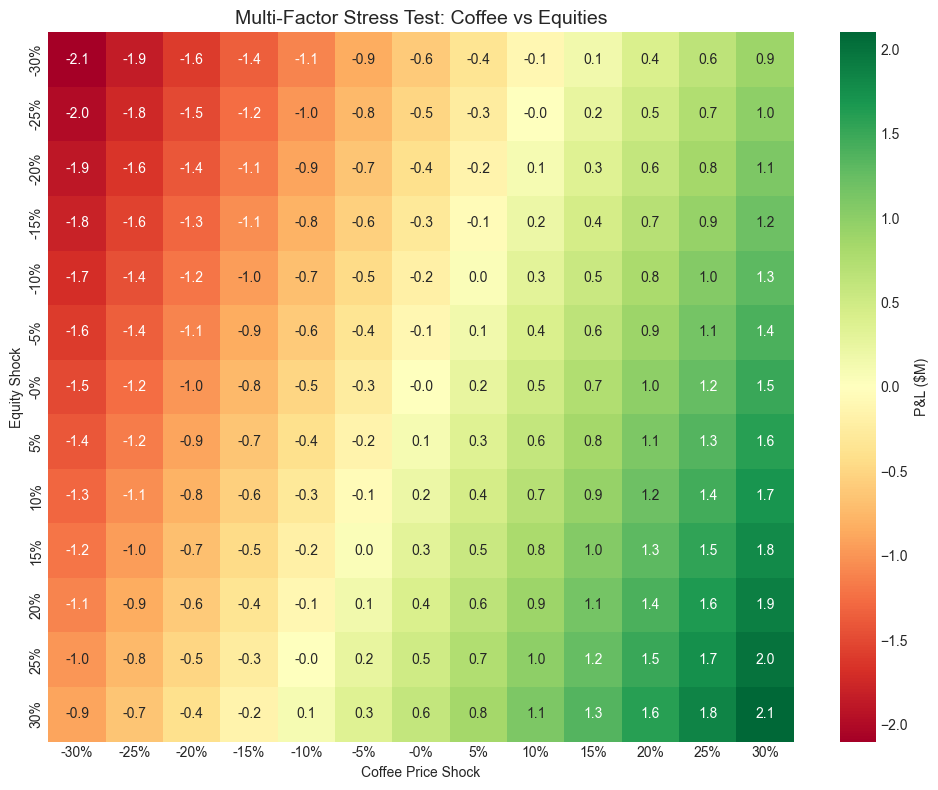

In [14]:
# create heatmap of combined shocks
coffee_shocks = np.arange(-0.30, 0.35, 0.05)
equity_shocks = np.arange(-0.30, 0.35, 0.05)

pnl_grid = np.zeros((len(equity_shocks), len(coffee_shocks)))

for i, eq_shock in enumerate(equity_shocks):
    for j, coffee_shock in enumerate(coffee_shocks):
        scenario = {'coffee': coffee_shock, 'equities': eq_shock}
        result = run_stress_test(portfolio, scenario)
        pnl_grid[i, j] = result['total']

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(pnl_grid / 1e6, 
            xticklabels=[f'{s:.0%}' for s in coffee_shocks],
            yticklabels=[f'{s:.0%}' for s in equity_shocks],
            cmap='RdYlGn', center=0, annot=True, fmt='.1f',
            ax=ax, cbar_kws={'label': 'P&L ($M)'})

ax.set_xlabel('Coffee Price Shock')
ax.set_ylabel('Equity Shock')
ax.set_title('Multi-Factor Stress Test: Coffee vs Equities', fontsize=14)

plt.tight_layout()
plt.savefig('../outputs/multifactor_stress.png', dpi=150)
plt.show()

## 7. Custom Scenario Builder

In [15]:
# build custom scenarios
custom_scenarios = {
    'mild_correction': {
        'description': 'Mild Market Correction',
        'coffee': -0.10,
        'equities': -0.08,
        'rates': 0.005,
        'fx_em': -0.05
    },
    'supply_shock': {
        'description': 'Coffee Supply Disruption',
        'coffee': 0.50,
        'equities': -0.02,
        'rates': 0.0,
        'fx_em': -0.08
    },
    'risk_off': {
        'description': 'Global Risk-Off Event',
        'coffee': -0.20,
        'equities': -0.25,
        'rates': -0.01,
        'fx_em': -0.20
    },
    'stagflation': {
        'description': 'Stagflation Scenario',
        'coffee': 0.30,
        'equities': -0.20,
        'rates': 0.025,
        'fx_em': -0.15
    }
}

print("CUSTOM SCENARIO RESULTS")
print("=" * 60)

for name, scenario in custom_scenarios.items():
    result = run_stress_test(portfolio, scenario)
    print(f"\n{scenario['description']} ({name}):")
    print(f"  Total P&L: ${result['total']:+,.0f}")
    print(f"  % of Portfolio: {result['total']/total_value*100:+.1f}%")

CUSTOM SCENARIO RESULTS

Mild Market Correction (mild_correction):
  Total P&L: $-712,500
  % of Portfolio: -8.4%

Coffee Supply Disruption (supply_shock):
  Total P&L: $+2,380,000
  % of Portfolio: +28.0%

Global Risk-Off Event (risk_off):
  Total P&L: $-1,695,000
  % of Portfolio: -19.9%

Stagflation Scenario (stagflation):
  Total P&L: $+937,500
  % of Portfolio: +11.0%


## 8. Historical Drawdown Analysis

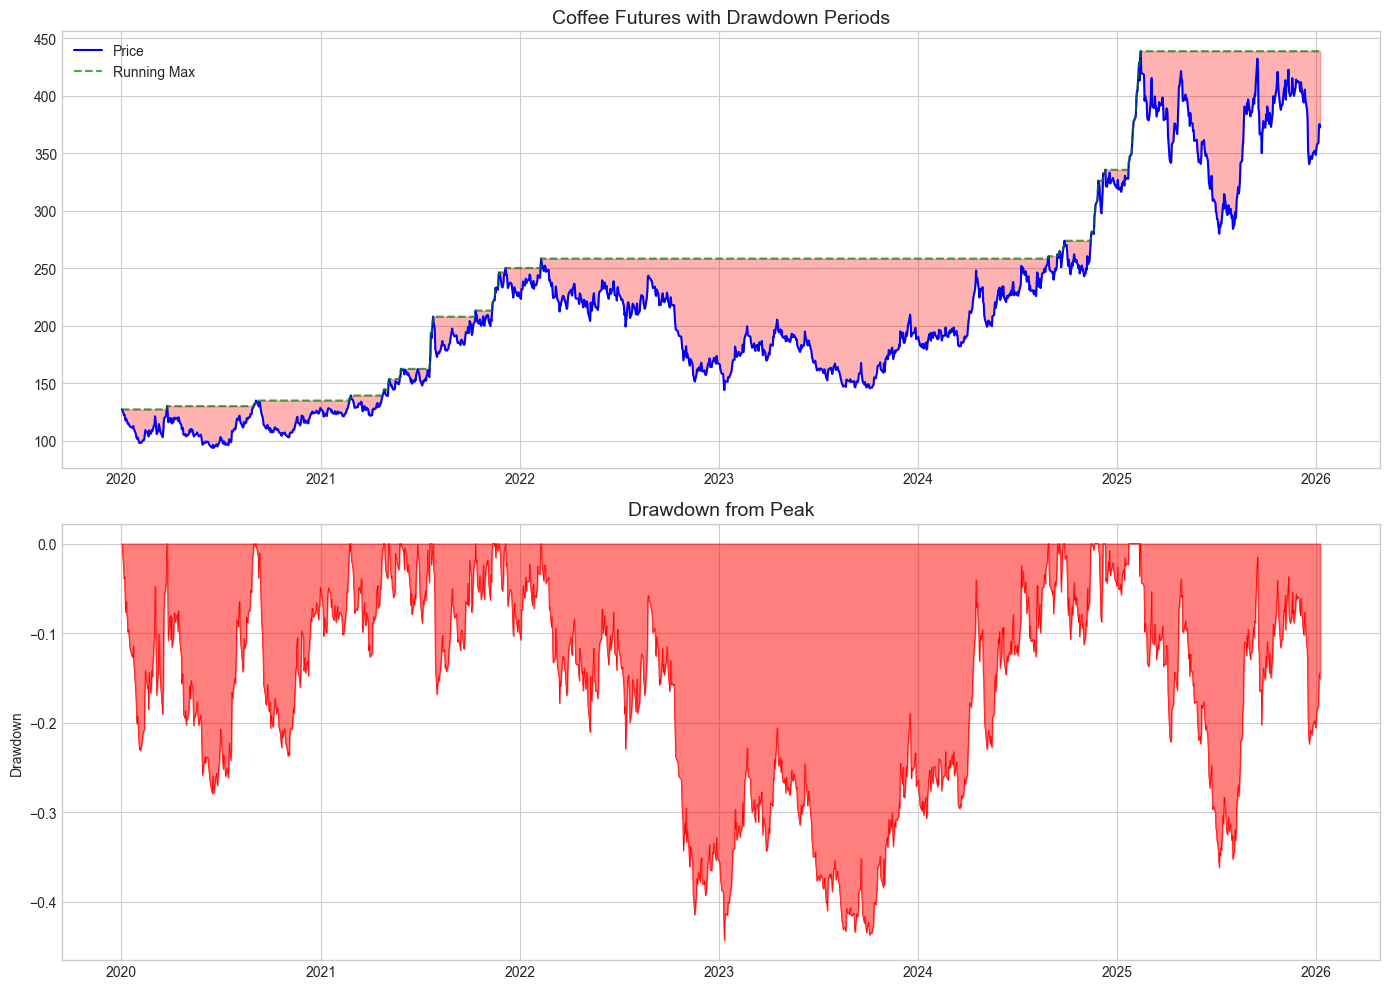


Maximum Drawdown: -44.30%
Current Drawdown: -15.09%
Average Drawdown: -16.32%


In [16]:
# load actual price data
df = load_csv('../data/coffee_futures.csv')
prices = df['Close']

# calculate drawdowns
rolling_max = prices.expanding().max()
drawdown = (prices - rolling_max) / rolling_max

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# price with rolling max
axes[0].plot(prices.index, prices, 'b-', label='Price')
axes[0].plot(prices.index, rolling_max, 'g--', alpha=0.7, label='Running Max')
axes[0].fill_between(prices.index, prices, rolling_max, alpha=0.3, color='red')
axes[0].set_title('Coffee Futures with Drawdown Periods', fontsize=14)
axes[0].legend()

# drawdown chart
axes[1].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.5)
axes[1].plot(drawdown.index, drawdown, 'r-', linewidth=0.5)
axes[1].set_title('Drawdown from Peak', fontsize=14)
axes[1].set_ylabel('Drawdown')

plt.tight_layout()
plt.savefig('../outputs/drawdown_analysis.png', dpi=150)
plt.show()

print(f"\nMaximum Drawdown: {drawdown.min():.2%}")
print(f"Current Drawdown: {drawdown.iloc[-1]:.2%}")
print(f"Average Drawdown: {drawdown.mean():.2%}")

## 9. Summary Report

In [17]:
print("\n" + "=" * 70)
print("STRESS TESTING SUMMARY REPORT")
print("=" * 70)

# find worst and best scenarios
all_results = run_all_scenarios(portfolio)
for name, scenario in custom_scenarios.items():
    result = run_stress_test(portfolio, scenario)
    all_results = pd.concat([all_results, pd.DataFrame([{
        'scenario': name,
        'description': scenario['description'],
        'total': result['total']
    }])], ignore_index=True)

worst = all_results.loc[all_results['total'].idxmin()]
best = all_results.loc[all_results['total'].idxmax()]

summary = f"""
PORTFOLIO OVERVIEW:
-------------------
Total Exposure: ${total_value:,.0f}
Main Position: Coffee (${portfolio['coffee']:,.0f} long)

STRESS TEST RESULTS:
--------------------
Scenarios Tested: {len(all_results)}
Worst Case: {worst['description']} (${worst['total']:+,.0f})
Best Case: {best['description']} (${best['total']:+,.0f})

KEY RISK INSIGHTS:
------------------
1. Coffee price drop of 30% would cause ${portfolio['coffee'] * -0.30:,.0f} loss
2. Maximum historical drawdown: {drawdown.min():.1%}
3. Supply shocks (frost, drought) could generate ${portfolio['coffee'] * 0.40:+,.0f} gain
4. Portfolio vulnerable to combined coffee crash + equity selloff

RECOMMENDATIONS:
----------------
1. Consider put options for downside protection below {-0.20:.0%}
2. Monitor Brazil weather forecasts closely
3. Review equity hedge allocation in risk-off scenarios
4. Stress test weekly during high volatility periods
"""

print(summary)


STRESS TESTING SUMMARY REPORT

PORTFOLIO OVERVIEW:
-------------------
Total Exposure: $8,500,000
Main Position: Coffee ($5,000,000 long)

STRESS TEST RESULTS:
--------------------
Scenarios Tested: 9
Worst Case: Global Financial Crisis ($-2,990,000)
Best Case: Major Frost in Coffee Regions ($+2,700,000)

KEY RISK INSIGHTS:
------------------
1. Coffee price drop of 30% would cause $-1,500,000 loss
2. Maximum historical drawdown: -44.3%
3. Supply shocks (frost, drought) could generate $+2,000,000 gain
4. Portfolio vulnerable to combined coffee crash + equity selloff

RECOMMENDATIONS:
----------------
1. Consider put options for downside protection below -20%
2. Monitor Brazil weather forecasts closely
3. Review equity hedge allocation in risk-off scenarios
4. Stress test weekly during high volatility periods

